# Function approximation: Least squares

In this notebook i will approximate given function using least squares method. We will build 3 polynomials: with degrees 0,1 and 2.

Consider following:\
    function values $f(x_i)$ are known only for some points of the grid $\omega = \{a \le x_0 < x_1 < \dots <x_N \le b\} \subset [a,b]. $\
$\varphi_1(x), \dots, \varphi_n(x)$ - linearly independent functions on $[a,b]$
    \
Our task is: out of polynomials of the form 

\begin{equation}\tag{1}\label{goal}
    Q_n(x) = a_1\varphi_1 + \dots + a_n \varphi_n(x)
\end{equation}

choose function

\begin{equation}
    Q_n^{*}(x) = \sum_{i=1}^n a_i^{*}\varphi_i(x)
\end{equation}

that 

\begin{equation}\tag{2}
    \parallel Q_n^{*} - f \parallel  \; = \min_{a_1, \dots, a_n} \parallel Q_n^{*} - f \parallel
\end{equation}



## Algorithm:
Given **N** - number of points
1. Choose **n** $\ll$ **N** - approximation number (as mentioned before,  $n \in 0,1,2$ ) and linearly independent functions system

2. Build system of linear equations:
\begin{equation}\label{eq:sole}\tag{3}
    \sum_{j=1}^n (\varphi_i,\varphi_j)_{\omega}a_j = (f,\varphi_i)_{\omega},\: i\in(1, \dots,n)
    \end{equation} where 
\begin{equation}
    \sum_{j=1}^n (\varphi_i,\varphi_j)_{\omega} = \sum_{k=1}^N (\varphi_i(x_k),\varphi_j(x_k))\\
    \sum_{j=1}^n (\varphi_i,f)_{\omega} = \sum_{k=1}^N (\varphi_i(x_k),f(x_k)) \\
\end{equation} and solve it for $a_1, \dots, a_n$

3. With found $a_1^{*}, \dots, a_n^{n}$ build target polynomial $Q_n^{*}$ in form

\begin{equation}
    Q_n^{*}(x) = \sum_{i=1}^n a_i^{*}\varphi_i(x)
\end{equation}


## Realisation

Let's begin by importing needed libraries. I will write formulas using $\LaTeX$, so we will need `Latex` and `display` from `IPython.display`. We will need `numpy` for calculations, `matplotlib.pyplot` for visualization. I will also use `%matplotlib inline` magic command.

In [1]:
import numpy as np
from IPython.display import Latex
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

I will be approximating following function:
\begin{equation}
(x-2)^2 2^x-1
\end{equation}

For linearly independent basis i will choose following functions:
\begin{equation}
\varphi_0 = 1, \varphi_1 = x, \varphi_2 = x^2
\end{equation}

Let's code functions mentioned above. Each of them will take an array-like parameter and return numpy-array. I will also use scalar product function.

In [2]:
# function which we are approximating
def function(x):
    return np.asarray((x - 2)**2 * 2**x -1)

# basis functions
def phi(x, deg):
    return np.asarray(x ** deg)

def scalar_product(a,b):
    return np.sum(a*b)

We need function, which takes grid nodes `x`, function values `f` and polynomial degree `deg` as parameters, builds system (3), solves it and returns coefficients $a_i^{*}$ `coefficients`.This process will be divided by 3 parts. 

**Note**: polynomial $P$ with $degP = n$ needs system of $n+1$ equations.

In [3]:
# this function builds left part of equation (3)
def build_left(x, deg):
    return np.asarray([[scalar_product(phi(x,i),phi(x,j)) for j in range(deg+1)] for i in range(deg+1)])


# this function builds right part of equation (3)
def build_right(x,f,deg):
    return np.asarray([scalar_product(phi(x,i),f) for i in range(deg+1)])


# this function solves equation (3) and returns polynomial coefficients
def find_coefficients(x,f,deg):
    a,b = build_left(x,deg), build_right(x,f,deg)
    coefficients = np.linalg.solve(a,b)
    return coefficients.ravel()

When we are able to find coefficients, it would be great to store them somewhere. Let's create small class `Polynomial`, so we can find values given certain x easily. For this i will create `calculate` method. I will override `__getitem__` - to easily get access to coefficients, and `__str__` - to print polynomial in more human-friendly format. Then this overrided method will be used to make `to_latex` function, which transforms our polynomial into beautiful math formula using $\LaTeX$ . 

In [4]:
class Polynomial:
    def __init__(self, coefficients):
        self.coefficients = coefficients
        self.deg = np.size(coefficients) - 1
        
        
    def __getitem__(self, key):
        return self.coefficients[key]

    def __str__(self):
        result =f"P_{{{self.deg}}}(x) = {str(self.coefficients[0])}"
        sign = {True: "+", False: "-"}
        form = "".join([f"{sign[self.coefficients[i] > 0]}({abs(self.coefficients[i])})x^{{{i}}}" for i in range(1,self.deg+1)])
        return result+form
    
    
    def to_latex(self):
        result =f"Q_{self.deg} = {str(self.coefficients[0])}"
        sign = {True: "+", False: ""}
        form = "".join(["{}{}x^{}".format(sign[self.coefficients[i] > 0],self.coefficients[i],i) for i in range(1,self.deg+1)])
        return Latex(f"""\\begin{{equation*}}
                {str(self)}
                \\end{{equation*}}""")
    
    
    def calculate(self,x):
        return sum([self.coefficients[i]* x**i for i in np.arange(self.deg+1)])
    
    


### Calculating errors

After we found coefficients, we are ready to calculate RMSE (Root Mean Square Error) and RRMSE (Relative Root Mean Square Error). The formulas are respectively:
\begin{equation*} 
\Delta_k = \sqrt{\sum_{i=0}^N(Q_k^{*}(x_i)-f(x_i))^2}  \\
\delta_k = \dfrac{\Delta_k}{\parallel f \parallel_\omega}\cdot 100\% 
\end{equation*} where $k$ - polynomial degree (in our case $k \in (0,1,2)$ )

Now we will define functions, which calculate $\Delta_i$ and $\delta_i$. They both take three required parameters: `x` - nodes from grid, `f` - respective function values and `poly` - `Polynomial` class instance. They also take two optional parameters `display_latex` and `decimal` for rounding.

In [5]:
# Root Mean Square Error aka Delta
def rmse(x,f,poly,display_latex=False,decimal=4):
    rmse_error = round(np.sqrt(np.sum((poly.calculate(x) - f)**2)),decimal)
    if display_latex:
        display(Latex(f"""\\begin{{equation*}}
                \Delta_{poly.deg} = \sqrt{{\sum_{{i=0}}^N(Q_{poly.deg}^{{*}}(x_i)-f(x_i))^2}} ={rmse_error}
                \\end{{equation*}}"""))
    return rmse_error


# Relative Root Mean Square Error aka delta
def rrmse(x,f,poly,display_latex=False,decimal=4):
    rmse_error = np.sqrt(np.sum((poly.calculate(x) - f)**2))
    rrmse_error = round(rmse_error / np.sqrt(scalar_product(f,f)) * 100,decimal)
    if display_latex:
        display(Latex(f"""\\begin{{equation*}}
                \delta_{poly.deg} = \dfrac{{\Delta_{poly.deg}}}{{\parallel f \parallel_\omega}}\\cdot 100\\% ={rrmse_error}
                \\end{{equation*}}"""))
    return rrmse_error

### Gathering everything

Now we are ready to solve our task: find approximating polynomials for given function on given node grid. We need to see original function plot, as well as 3 other plots: for polynomials with degree 0,1 and 2. We will plot them on the same figure.

Lets first plot our nodes grid and target function, and then create cycle to:
1. Build polynomial with degree ***i***
2. Plot it
3. Print it's formula in $\LaTeX$
4. Calculate it's RMSE and RRMSE

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

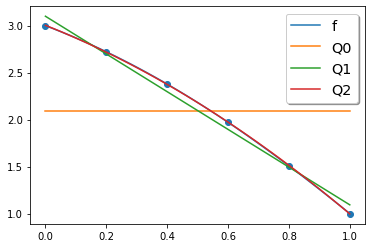

<Figure size 720x720 with 0 Axes>

In [6]:
a,b = [0,1] # given section
N = 5 # nodes quantity
decimal = 4 # for rounding
max_deg = 2 # max degree in for loop

x_ = np.linspace(a,b,40, endpoint=True) # we will use this to plot functions
x = np.linspace(a,b,N+1) # nodes grid
f = function(x) # funciton values


fig,ax = plt.subplots()
plt.figure(figsize=(10,10))
ax.plot(x_,function(x_), label="f")
ax.scatter(x,f)


# i will save rmse's and rrmse's for future
rms_errors  = np.zeros(shape=(max_deg+1,))
rrms_errors = np.zeros(shape=(max_deg+1,))
# i will save coefficients for future
coef_matrix = np.zeros(shape=(max_deg+1,max_deg+1))


for deg in np.arange(max_deg+1):
    coefs = find_coefficients(x,f,deg)
    poly = Polynomial(np.round(coefs,4))
    ax.plot(x_,poly.calculate(x_),label="Q{}".format(deg))
    display(poly.to_latex()) # or print(poly) if we don't need LaTeX representation
    
    rms_errors[deg] = rmse(x,f,poly,display_latex=True,decimal=decimal)
    rrms_errors[deg] = rrmse(x,f,poly,display_latex=True,decimal=decimal)
    coef_matrix[deg] += np.hstack((coefs,np.asarray([0 for i in np.arange(max_deg-deg)])))
    

legend = ax.legend(loc='best', shadow=True, fontsize='x-large')

#fig.savefig('approximation_least_squares.png') #save our plot

We have successfully completed our task. Now we can save our data to `pandas` `DataFrame` to store it.

In [7]:
import pandas as pd
pd.options.display.max_rows
values = {'x_i':x,'y_i':f}
xy_data = pd.DataFrame(values,columns=values.keys())
xy_data.head(np.size(x))

,x_i,y_i
0,0.0,3.000000
1,0.2,2.721783
2,0.4,2.377940
3,0.6,1.970804
4,0.8,1.507186
5,1.0,1.000000


In [8]:
poly_info = pd.DataFrame(coef_matrix,columns=['a{}_i'.format(i) for i in range(max_deg+1)])
poly_info['Delta'] = rms_errors
poly_info['delta'] = rrms_errors
poly_info.head(max_deg+1)

,a0_i,a1_i,a2_i,Delta,delta
0,2.096286,0.000000,0.000000,1.6888,31.2420
1,3.099923,-2.007275,0.000000,0.1775,3.2831
2,3.003260,-1.282299,-0.724976,0.0099,0.1840
